#  Notebook 3 of MBC topic modeling in BHC. 
***
This notebook is processing data from MBC websites 
***

In [1]:
# This is the library of packages used in this model with a comment as to why they are needed

# Turn off pesky warnings
import warnings
warnings.filterwarnings("ignore")

# Need numpy and pandas for easier data manipulation
import pandas as pd
import numpy as np

# In order to save data at intermediate points for Excel pivoting and visualization, need the ability to write data to csv
import csv

from openpyxl import load_workbook

# Need datetime for manipulating date-time data in analysis and filtering
import datetime

# Bring in the copy package in case we need it to copy some lists or dataframes
import copy

# Need matplotlib and seaborne for visualizing the data
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt 

# show all columns when displaying pandas dfs
pd.set_option('display.max_columns', None)

# show a time running when executing long loops
from tqdm import tqdm

# Needed for parralellizing the running of the lemmatization and lda model runs, saves big time when assessing data
from joblib import Parallel, delayed 

# Need to be able to hit urls for some of the data tools
import requests

# Bring in the package for regular expressions for easier data manipulation
import re
import pickle
from tqdm import tqdm

# To enable pretty printing, we need to load pprint
from pprint import pprint

# Import the applicable gensim package components for manipulating data and doing LDA modeling
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# bring in spacy for lemmatization of our corpora
import spacy

# Plotting tools that we will need to use 
import pyLDAvis
import pyLDAvis.gensim_models

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en ... This was needed when first setting up spacy in the environment
nlp = spacy.load('en_core_web_sm')

# Bring in tqdm to track progress of for loops
from tqdm import tqdm

# Turn off pesky warnings by ignoring deprecation warnings
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import os

C:\Users\becky\anaconda3\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [2]:
df = pd.read_csv('MBC Dataset Combined.csv')
df.head()

,company,document_type,document_format,title,text
0,Azzly,Who_we_serve,web_page,Addiction Treatment Providers,Medication-Assisted Treatment AZZLY Rize simpl...
1,Azzly,Product_info,web_page,Analytics,An essential step for any business seeking to ...
2,Azzly,Product_info,web_page,Billing/RCM,Billing/RCM MAT labs can click once and add a...
3,Azzly,Product_info,web_page,Capitation,AZZLY Reporting for Capitation Billing Overvie...
4,Azzly,Product_info,web_page,Electronic Health Record,Integrated Care Pathways AZZLY's Integrated Ca...


In [3]:
# NLTK Stop words - We have already downloaded the stopwords. Let’s import them and make it available in stop_words, adding a few ones for our purposes
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'azzly', 'bhwork', 'bhworks', 'mdlogix', 'blueprint', 'celestHealth', 'greenspace', 'holmusk', 'horizon', 'ksana', 'mirah', 'myoutcome', 'myoutcomes', 'neuroblu', 'neuroflow', 'nextstep', 'nview', 'owl', 'silvercloud', 'tridiuum', 'valant', 'vivi', 'vivihealth', 'rize', 'pcoms', 'vivicompanion', 'richard', 'richards', 'duncan', 'lambert', 'kollin', 'kollins', 'reese', 'miller', 'com', 'non', 'pre'])

# Now lets take a look at how many stop words we have in our extended list
print("There are", len(stop_words), "stop words.")

There are 221 stop words.


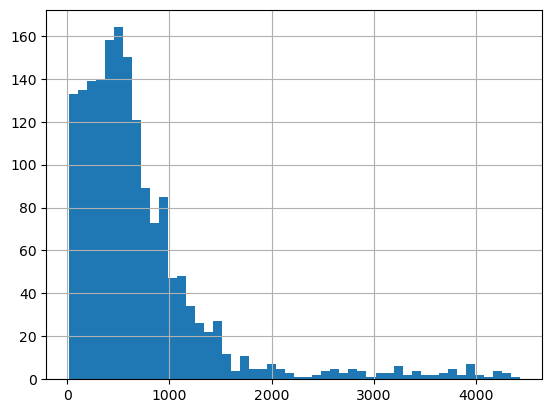

In [19]:
# Get the count of words in each document
word_count_before = pd.Series([len(i.split()) for i in df.text])
word_count_before.hist(bins = 50)
word_count_before.to_csv("Count of words before preprocessing.csv")

In [5]:
# Create the function to loop through and do our lemmatization
def lemmatization(text, allowed_postags):
    doc = nlp(text)
    return([token.lemma_ for token in doc if token.pos_ in allowed_postags])

# Prep the list we will use to store the lemmatized words and the define the allowable word types for keeping
data_words = []
allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV', 'PROPN']

# Now loop through the texts and create a lemmatized list of words that we will save in a list of lists
for text in tqdm(df.text):
    data_words.append(lemmatization(text, allowed_postags))

100%|██████████| 1719/1719 [03:12<00:00,  8.94it/s]


In [6]:
#First thing we need to do is bring in the url and create the dictionary with brit spellings as key and american as value
url ="https://raw.githubusercontent.com/hyperreality/American-British-English-Translator/master/data/british_spellings.json"
british_to_american_dict = requests.get(url).json()    
british_to_american_dict

# Next we need to define a function to do the swap outs in parallel
def americanize(word_list, swap_dict):
    dl1 = []
    for word in word_list:
        if word in swap_dict:
            dl1.append(swap_dict[word])
        else:
            dl1.append(word)
    return(dl1)

# Set up for the parallel processing parameters
num_CPUs = 10
isVisual = 5

# Then run a parallel job to do all the swap outs
data_words1 = Parallel(n_jobs = num_CPUs, verbose = isVisual, batch_size = 30)(delayed(americanize)(word_list, british_to_american_dict) 
                                                                              for word_list in data_words)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  16 tasks      | elapsed:    4.1s
[Parallel(n_jobs=10)]: Done 1522 tasks      | elapsed:    4.5s
[Parallel(n_jobs=10)]: Done 1612 tasks      | elapsed:    4.7s
[Parallel(n_jobs=10)]: Done 1719 out of 1719 | elapsed:    4.9s finished


In [7]:
# Define our function to loop through
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc), max_len = 30) if word not in stop_words] for doc in texts]

# Then remove the stopwords
data_words2 = remove_stopwords(data_words1)

In [8]:
# This function will take in a list of words and remove any words that are smaller than 3 characters
def remove_short_words(word_list, min_length):
    count = 0
    # Create paceholder list to build with word_list and replaced acronyms
    dl2 = []
    
    # Cycle through the word list and check if that word is a plural in the dictionary
    for word in word_list:
        
        # If long enough, keep the word, otherwise remove it
        if len(word) >= min_length:
            dl2.append(word)
        else:
            count = count + 1
    
#     if count > 0:
#         print("replaced ", count, "words")
        
    return(dl2)

# Create the list we will use to capture the results
data_words3 = list()

# Run the function to remove short words of 1 or 2 characters
for word_list in tqdm(data_words2):
    data_words3.append(remove_short_words(word_list, 3))

100%|██████████| 1719/1719 [00:00<00:00, 15169.42it/s]


In [9]:
# Create the function to loop through and do our lemmatization
def lemmatization(text, allowed_postags):
    doc = nlp(" ".join(text))
    return([token.lemma_ for token in doc if token.pos_ in allowed_postags])

# We've already defined the lemmatization function above, so we just need to rerun it and save the result in a list of lists
data_words4 = list()

for word_list in tqdm(data_words3):
    data_words4.append(lemmatization(word_list, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']))

100%|██████████| 1719/1719 [01:31<00:00, 18.84it/s]


In [10]:
with open("Preprocessed data.pickle", 'wb') as f:
    pickle.dump(data_words4, f)

In [11]:
# Create Dictionary
id2word = corpora.Dictionary(data_words4)

# Create Corpus
corpus = [id2word.doc2bow(text) for text in data_words4]

# Bring in the getsizeof function to figure out from sys import getsizeof
# Create a numpy array of integers that has rows = len(words) & columns = len(documents)
wca = np.zeros((len(id2word), len(data_words4)), dtype=np.int64)
print("array size is ", wca.shape)

# Cycle through the corpus to get the count of each word in the document, then save that in the numpy array
for count, doc in tqdm(enumerate(corpus)):
    for i in doc:
        wca[i[0]][count] = i[1]


# Calculate the total count of times a word is in the population by counting across the documents
word_counts = np.sum(wca, axis = 1)

# Calculate the number of documents a word appears incapturing the nonzero counts in each document
word_in_docs_count = np.count_nonzero(wca, axis = 1)

# Get the list of words out of the dictionary and put it into a dataframe
word_list = [id2word[count] for count, i in enumerate(id2word)]
word_info = pd.DataFrame(word_list)
word_info.columns = ['word']

# Add in two columns with the info of word counts in population and the number of documents the word is in
word_info['word_count'] = word_counts
word_info['num_documents_with_word'] = word_in_docs_count

# Save the dataframe for investigation offline 
word_info_filename = "Word summary stats in corpus" + ".csv"
word_info.to_csv(word_info_filename)

array size is  (13348, 1719)


1719it [00:00, 9914.22it/s]
